In [1]:
import numpy as np
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import ResNet50

SEED = 42
import random 
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

# ** Inputs **

In [2]:
# Choose which image folder name you want to use.
image_folder_name = 'FMD_tvt'

#image size
img_size = (150, 150)

#expected input shape Model, (FIRST TWO VALUES MUST BE THE SAME AS img_size)
img_shape = (150, 150, 3)

#Batch Size of Data
batch_size = 32


Model_save_name = 'MobilNet.h5'


# Setup of Paths and Values

In [3]:
tvt_folders = ['train', 'val', 'test']
im_folders = ['image', 'mask']

Fmd_class_path = os.path.join(image_folder_name, tvt_folders[0], im_folders[0])
classes = os.listdir(os.path.join(Fmd_class_path))
print(classes)

['fabric', 'foliage', 'glass', 'leather', 'metal', 'paper', 'plastic', 'stone', 'water', 'wood']


In [4]:
image_path_train = os.path.join(image_folder_name, tvt_folders[0], im_folders[0])
mask_path_train = os.path.join(image_folder_name, tvt_folders[0], im_folders[1])

image_path_val = os.path.join(image_folder_name, tvt_folders[1], im_folders[0])
mask_path_val = os.path.join(image_folder_name, tvt_folders[1], im_folders[1])

# Load in Data and Make Datasets

Define Three functions

In [5]:
def fun_load_image(x):
    byte_img = tf.io.read_file(x) #Tensorflow way of loading in image
    img = tf.io.decode_jpeg(byte_img)  #Need both lines of code
    return img

In [6]:
def make_dataset_imgs(tvt_folder, classes, img_size):
    ds = tf.data.Dataset.list_files(os.path.join(image_folder_name, tvt_folder, 'image', classes[0], "*.jpg"), shuffle=False)
    for i in range(len(classes)-1):
        ds_class = tf.data.Dataset.list_files(os.path.join(image_folder_name, tvt_folder, 'image', classes[i+1], "*.jpg"), shuffle=False)
        ds = ds.concatenate(ds_class)

    ds = ds.map(fun_load_image)
    ds = ds.map(lambda x: tf.image.resize(x, img_size))
    ds = ds.map(lambda x: x/255)
    return ds


In [7]:
def make_dataset_labels(image_path):
    class_labels = []
    for class_ in classes:
        class_val = classes.index(class_)
        num_in_class = len(os.listdir(os.path.join(image_path, class_)))
        class_labels_ = [class_val]*num_in_class
        class_labels = class_labels + class_labels_

    label_ds = tf.data.Dataset.from_tensor_slices(class_labels)
    return label_ds

Training Data

In [8]:
train_ds = make_dataset_imgs(tvt_folders[0], classes, img_size)
train_labels_ds = make_dataset_labels(image_path_train)

Validation Data

In [9]:
val_ds = make_dataset_imgs(tvt_folders[1], classes, img_size)
val_labels_ds = make_dataset_labels(image_path_val)

# Zipping and Shuffle

In [11]:
train = tf.data.Dataset.zip((train_ds, train_labels_ds))
train = train.shuffle(10000)

val = tf.data.Dataset.zip((val_ds, val_labels_ds))
val = val.shuffle(10000)

# Sample Check

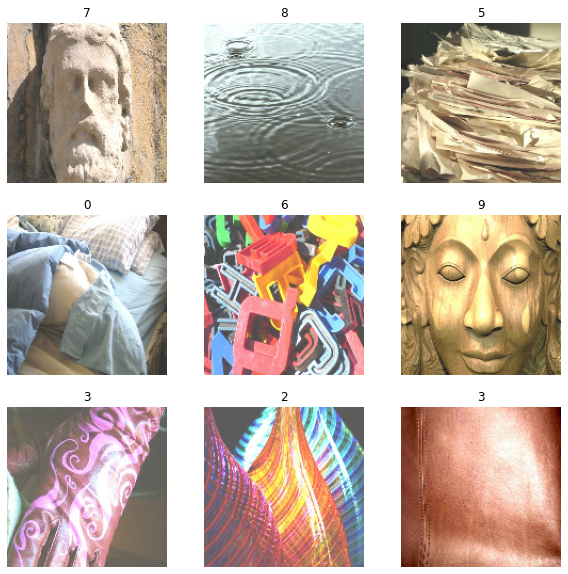

In [12]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

# Batch and Prefetch

In [13]:
#Just speeds up the computation-Need to look into it more!!!
train = train.cache().batch(batch_size).prefetch(buffer_size=10)
val = val.cache().batch(batch_size).prefetch(buffer_size=10)

# Building Model

In [14]:
base_model = tf.keras.applications.MobileNet(
    weights = 'imagenet', 
    input_shape = img_shape, #State the size of the images
    include_top = False #Do not include the Imagenet Classifier at the top
)
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                         

In [15]:
# #Freeze the model
base_model.trainable = False

#Create a new model on top
inputs = tf.keras.Input(shape = img_shape)

x = base_model(inputs, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x) #Same job as flattening but in a different way. Bridges convolutional structure to traditional neural network
x = tf.keras.layers.Dropout(0.2)(x) # Regularize with dropout
x = tf.keras.layers.Dense(256, activation= "relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation= "relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation= "relu")(x)

outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [16]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [17]:
epochs = 50
history = model.fit(train, epochs = epochs, validation_data = val, callbacks=[tf.keras.callbacks.EarlyStopping(patience=7, monitor='val_sparse_categorical_accuracy', restore_best_weights= True)])

Epoch 1/50
19/19 [==============================] - 9s 367ms/step - loss: 2.4756 - sparse_categorical_accuracy: 0.1457 - val_loss: 1.9262 - val_sparse_categorical_accuracy: 0.4100
Epoch 2/50
19/19 [==============================] - 6s 324ms/step - loss: 1.8524 - sparse_categorical_accuracy: 0.3585 - val_loss: 1.4855 - val_sparse_categorical_accuracy: 0.5950
Epoch 3/50
19/19 [==============================] - 6s 325ms/step - loss: 1.3292 - sparse_categorical_accuracy: 0.5611 - val_loss: 1.1543 - val_sparse_categorical_accuracy: 0.6550
Epoch 4/50
19/19 [==============================] - 6s 327ms/step - loss: 1.0437 - sparse_categorical_accuracy: 0.6516 - val_loss: 1.0504 - val_sparse_categorical_accuracy: 0.6950
Epoch 5/50
19/19 [==============================] - 6s 322ms/step - loss: 0.7421 - sparse_categorical_accuracy: 0.7571 - val_loss: 0.9945 - val_sparse_categorical_accuracy: 0.6950
Epoch 6/50
19/19 [==============================] - 6s 319ms/step - loss: 0.6310 - sparse_categorica

In [18]:
# Save the entire model as a SavedModel.
if not os.path.exists:
    os.makedirs('Models')
model.save(os.path.join('Models', Model_save_name))

# Final Validation Accuracy

In [19]:
print(f'Final Validation Accuracy = {np.round(max(history.history["val_sparse_categorical_accuracy"]), 4)}')

Final Validation Accuracy = 0.755
